## Section 1: Estimating model parameters
在这一章，我们要探讨贝叶斯派是如何think数据的，并且我们要通过MCMC技术来拟合模型参数。

In [10]:
from IPython.display import Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as stats
import scipy.optimize as opt
import statsmodels.api as sm

%matplotlib inline
plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

messages = pd.read_csv('data/hangout_chat_data.csv')

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


贝叶斯如何思考数据？

频率派将概率分布函数的参数值固定死，贝叶斯却将概率分布函数的参数值看做随机变量，这个随机变量符合某种未知的概率分布，通过观察已有的数据得出参数值的最优估计值。

由于下面的例子都是非负数，所以通常使用Poisson分布来拟合数据。Poisson分布使用单变量$\mu$描述数据的均值和方差。下面给出三个不同$\mu$值的例子。
$$ p(x \ | \ \mu) = \frac{e^{-\mu}\mu^{x}} {x!} \mbox { for } x = 0,1,2, \cdots$$

$$\lambda = E(x) = Var(\mu)$$


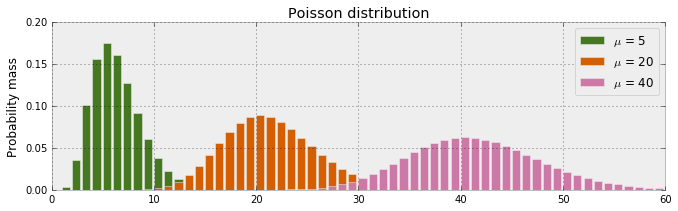

In [2]:
fig = plt.figure(figsize=(11, 3))
ax = fig.add_subplot(111)
x_lim = 60
mu = [5, 20, 40]
for i in np.arange(x_lim):
    plt.bar(i, stats.poisson.pmf(mu[0], i), color=colors[3])
    plt.bar(i, stats.poisson.pmf(mu[1], i), color=colors[4])
    plt.bar(i, stats.poisson.pmf(mu[2], i), color=colors[5])

ax.set_xlim(0, x_lim)
ax.set_ylim(0, 0.2)
ax.set_ylabel('Probability mass')
ax.set_title('Poisson distribution')
plt.legend(['$\mu$ = %s' % mu[0], '$\mu$ = %s' % mu[1], '$\mu$ = %s' % mu[2]])

我们已经导入了hangout chat dataset。我特别关心我回应消息的延迟时间(response_time)。将`response_time`作为count data，我们可以把它拟合到Poisson分布，并且估计它的参数$\mu$。我们将会分别尝试用频率派和贝叶斯派方法来计算这个参数值。

(array([  7.,   7.,  10.,  12.,  12.,   4.,  18.,   4.,  17.,  15.,  28.,
         10.,  11.,   9.,   8.,   7.,   8.,   8.,  11.,   7.,   2.,   6.,
          4.,  11.,   6.,  11.,   3.,   6.,   6.,   2.,   5.,   7.,   1.,
          6.,   5.,   3.,   1.,   4.,   1.,   1.,   2.,   2.,   2.,   1.,
          3.,   1.,   4.,   2.,   1.,   2.,   2.,   1.,   1.,   1.,   2.,
          3.,   1.,   1.,   2.,   0.]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
         33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
         44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
         55.,  56.,  57.,  58.,  59.,  60.]),
 <a list of 1 Patch objects>)

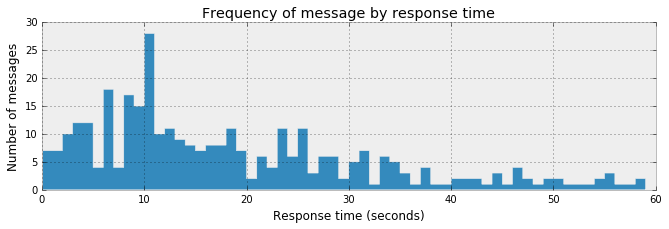

In [3]:
fig = plt.figure(figsize=(11, 3))
plt.title('Frequency of message by response time')
plt.xlabel('Response time (seconds)')
plt.ylabel('Number of messages')
plt.hist(messages['time_delay_seconds'].values, range=[0, 60], bins=60, histtype='stepfilled')

### 频率派方法估计$\mu$值
我们将用优化技术去拟合Possion分布的最大似然估计函数。

函数`poisson_logprob()`返回给定Poisson模型和参数个数的情况下，返回所有可能的参数似然估计值。我们用方法`opt.minimize_scalar`来找到最置信的$\mu$值（最大似然估计值）。该优化函数通过智能地迭代选择可能的$\mu$值，直到得到满足最大似然值的$\mu$值。

In [4]:
y_obs = messages['time_delay_seconds'].values

# 为了解决概率值过小的问题，用log函数转化概率值，求和是因为最大似然估计函数就是要让观测数据拟合到指定分布的概率之和最大
def poisson_logprob(mu, sign=-1):
    return np.sum(sign * stats.poisson.logpmf(y_obs, mu=mu))

# 因为要poisson_logprob得到的值最大，但这个函数是目标函数的最小值优化，所以sign取负数。
freq_results = opt.minimize_scalar(poisson_logprob)
%time print('The estimated value of mu is: %s' %  freq_results['x'])

The estimated value of mu is: 18.2307692324
Wall time: 0 ns


得到了$\mu = 18.23$。但是这个优化函数不提供任何关于不确定性的衡量，它仅仅返回一个点估计，还有就是速度很快。

下图画出了优化函数的优化过程。对每个$\mu$值，图中都对应画出了在poisson分布下，其对应的log probability值。整个优化过程就像是在登山——在曲线上随机选择一个点，然后尽可能爬上更高的高度。

(1, 60)

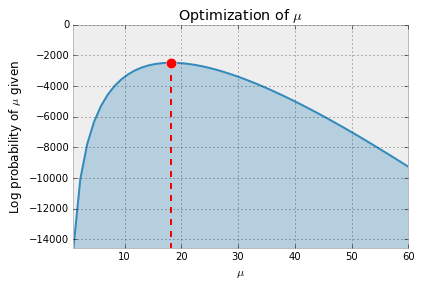

In [5]:
x = np.linspace(1, 60)
y_min = np.min([poisson_logprob(i, sign=1) for i in x])    # 不同mu值得到的最大似然估计值，取最小的
y_max = np.max([poisson_logprob(i, sign=1) for i in x])    

fig = plt.figure(figsize=(6, 4))
plt.plot(x, [poisson_logprob(i, sign=1) for i in x])  # 不同mu值的对应的已知数据下，最大的似然估计值
plt.fill_between(x, [poisson_logprob(i, sign=1) for i in x], y_min, color=colors[0], alpha=0.3)
plt.title('Optimization of $\mu$')
plt.xlabel('$\mu$')
plt.ylabel('Log probability of $\mu$ given ')
plt.vlines(freq_results['x'], y_max, y_min, color='red', linestyles='dashed')
plt.scatter(freq_results['x'], y_max, s=110, c='red', zorder=3)
plt.ylim(ymin=y_min, ymax=0)
plt.xlim(xmin=1, xmax=60)

我们知道任何Poisson分布的参数$\mu$代表这个分布的均值和方差。下面的图可视化这个结论。

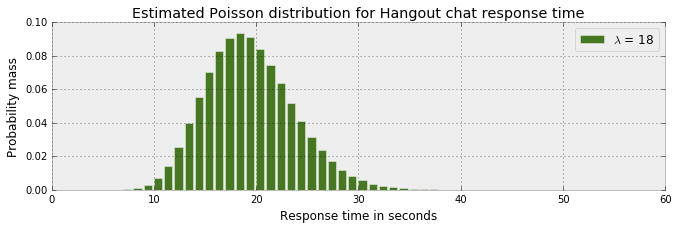

In [6]:
fig = plt.figure(figsize=(11, 3))
ax = fig.add_subplot(111)
x_lim = 60
mu = np.int(freq_results['x'])
for i in np.arange(x_lim):
    plt.bar(i, stats.poisson.pmf(mu, i), color=colors[3])

ax.set_xlim(0, x_lim)
ax.set_ylim(0, 0.1)
ax.set_xlabel('Response time in seconds')
ax.set_ylabel('Probability mass')
ax.set_title('Estimated Poisson distribution for Hangout chat response time')
plt.legend(['$\lambda$ = %s' % mu])

从上图可以观察到，这个分布里不太可能观测到小于10或大于30的值出现，且主要的值出现在10到30之间，但是这和我们真实数据是不一致的，真实数据的范围是0到60.

### 贝叶斯估计$\mu$值
贝叶斯方法就是如下公式：

$$\overbrace{p(\mu \ |\ Data)}^{\text{posterior}} = \frac{\overbrace{p(Data \ | \ \mu)}^{\text{likelihood}} \cdot
\overbrace{p(\mu)}^{\text{prior}}} {\underbrace{p(Data)}_{\text{marginal likelihood}}}$$

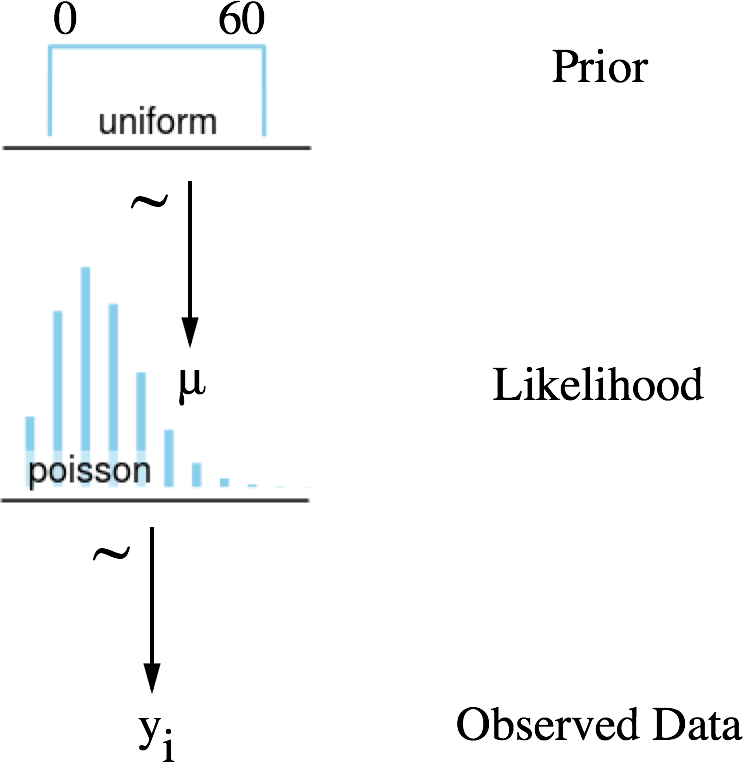

In [7]:
Image('graphics/Poisson-dag.png', width=320)

上面的内容可以解释为：
* 我们获得观测数据data(y)
* 这组观测数据是由某个随机过程产生的，我们人为将这个随机过程指定为Poisson分布(Likelihood)
* 这个Poisson分布有个单变量$\mu$，我们认为这个$\mu$值也是由某个随机过程产生的，我们人为将这个随机过程指定为uniform分布，范围从0到60(Prior)
    * 我们将$\mu$指定为uniform分布是因为我们没有任何可以参照的建议说$\mu$可能是来自哪个随机过程

### MCMC模型的神奇之处
Markov Chain Monte Carlo(MCMC)过程可视化为如下的动画。MCMC对参数的先验分布进行采样，并计算在采样的参数下，观测数据的最大似然估计值，得到对应的采样参数的后验估计值。

$$\overbrace{p(\mu \ |\ Data)}^{posterior} \varpropto \overbrace{p(Data \ | \ \mu)}^{likelihood} \cdot \overbrace{p(\mu)}^{prior}$$

这个计算得到的分布函数的参数的后验估计值作为MCMC参数采样器的优化指示灯。这样不断的重复，会引导参数采样器向着能使得观测数据得到高似然估计值的高概率区域采样。

和频率派类似的是，MCMC采样器向着最高似然估计值的区域进行分布函数的参数采样。不同的是，贝叶斯方法不关心采样到的参数是否满足观测数据的最高的似然估计值，它更关心采样到的参数值要在使得观测数据得到高似然估计值的高概率区域中采样。这样所有采样得到的参数值都可认为是置信的分布函数参数值。

In [8]:
Image(url='graphics/mcmc-animate.gif')

上图中，画出了$\mu$值的分布集合。分布的均值总是和频率派方法估计的$\mu$值一致（红色的线）。然而，我们同时还得到了衡量$\mu$值不确定性的方法，这里$\mu$的置信范围在17到19之间。这种不确定性的计算方法是非常有价值的，我们后面会看到这点。

下面的代码通过200.000次迭代计算$\mu$的后验分布中，导致观测数据高似然估计值的高概率区域，采集200.000个置信的$\mu$值。

In [12]:
with pm.Model() as model:
    mu = pm.Uniform('mu', lower=0, upper=60)
    likelihood = pm.Poisson('likelihood', mu=mu, observed=messages['time_delay_seconds'].values)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(200000, step, progressbar=True)

Optimization terminated successfully.
         Current function value: 2487.323198
         Iterations: 5
         Function evaluations: 8
         Gradient evaluations: 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200500/200500 [51:20<00:00, 61.59it/s]


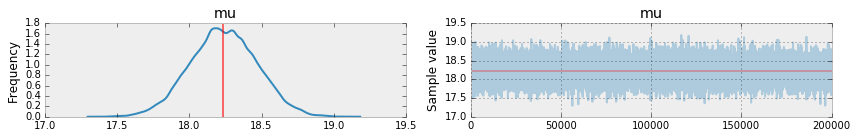

In [16]:
_ = pm.traceplot(trace, varnames=['mu'], lines={'mu': freq_results['x']})

### Discarding early samples (burnin)
MAP代表最大后验估计值(maximum a posteriori estimation)。它帮助MCMC采集器找到一个好的位置开始采样。理想情况下，它帮助采集器从高似然估计值区域开始采样，但是这只是理想情况。因此，采集器采集到的早期的参数值通常将会被丢弃。

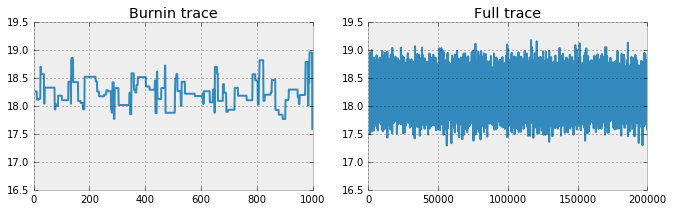

In [13]:
fig = plt.figure(figsize=(11, 3))
plt.subplot(121)
plt.title('Burnin trace')
plt.ylim(ymin=16.5, ymax=19.5)
plt.plot(trace.get_values('mu')[:1000])
fig = plt.subplot(122)
plt.title('Full trace')
plt.ylim(ymin=16.5, ymax=19.5)
plt.plot(trace.get_values('mu'))

### Model convergence

#### Trace
上述的MCMC模型估计了$\mu$的取值，但并不意味着这个模型能够预测出好的data。这里有些建议来帮助检查模型质量。首先，观察trace的输出结果，好的trace应该是在某个范围里跳跃，画出来就像一个毛毛虫。如果发现trace是尖尖的一上一下或者卡在某个位置——这个信号说明模型出现了无法收敛的问题，这样的模型是不可置信的。

#### Autocorrelation plot
第二个建议是进行autocorrelation test（看下图）。它是MCMC采样链中度量连续采样值之间相关性的工具。如果样本之间相关性低的话，这说明采样值加入了更多关于估计好的参数值的“信息”。

观察下图，autocorrelation plot会快速的逐渐下降到0，然后再其附近震荡。如果模型得出的autocorrelation plot不是这样，那么通常是个危险信号，说明需要考虑模型的选择或者采样的方式。

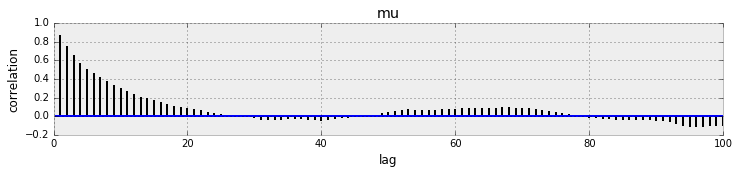

In [14]:
_ = pm.autocorrplot(trace[:2000], varnames=['mu'])

### References
- [MCMC animation by Maxwell Joeseph](http://blog.revolutionanalytics.com/2013/09/an-animated-peek-into-the-workings-of-Bayesian-statistics.html)

In [43]:
# Apply pretty styles
from IPython.core.display import HTML

def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()